In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from xgboost import XGBClassifier
import shap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [4]:
data = pd.read_csv("Dataset.csv")
data.head()

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,30-07-2010,1056903,1,4941,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,16-09-2010,8670,1,7374,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,23-11-2010,8858,1,5065,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,29-06-2010,1035201,1,4941,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,14-07-2010,721371,1,5122,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [5]:
# Display the distribution of outcomes
print(data['Binary Rating'].value_counts())
data.groupby

Binary Rating
1    5099
0    2706
Name: count, dtype: int64


<bound method DataFrame.groupby of                            Rating Agency                     Corporation  \
0     Standard & Poor's Ratings Services       American States Water Co.   
1     Standard & Poor's Ratings Services  Automatic Data Processing Inc.   
2     Standard & Poor's Ratings Services                      Avnet Inc.   
3     Standard & Poor's Ratings Services    California Water Service Co.   
4     Standard & Poor's Ratings Services            Cardinal Health Inc.   
...                                  ...                             ...   
7800           Moody's Investors Service                      eBay, Inc.   
7801           Moody's Investors Service                      eBay, Inc.   
7802  Standard & Poor's Ratings Services       iHeartCommunications Inc.   
7803  Standard & Poor's Ratings Services       iHeartCommunications Inc.   
7804  Standard & Poor's Ratings Services       iHeartCommunications Inc.   

     Rating Rating Date      CIK  Binary Rating  SIC

In [6]:
print(data.shape)
data.info()


(7805, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Rating Agency                  7805 non-null   object 
 1   Corporation                    7805 non-null   object 
 2   Rating                         7805 non-null   object 
 3   Rating Date                    7805 non-null   object 
 4   CIK                            7805 non-null   int64  
 5   Binary Rating                  7805 non-null   int64  
 6   SIC Code                       7805 non-null   int64  
 7   Sector                         7805 non-null   object 
 8   Ticker                         7805 non-null   object 
 9   Current Ratio                  7805 non-null   float64
 10  Long-term Debt / Capital       7805 non-null   float64
 11  Debt/Equity Ratio              7805 non-null   float64
 12  Gross Margin                   7805 n

In [7]:
num_cols = data.select_dtypes(include=['float64', 'int64']) 
cat_cols = data.select_dtypes(include=['object']) 

print("Numeric Variables:")
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())

Numeric Variables:
['CIK', 'Binary Rating', 'SIC Code', 'Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin', 'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover', 'ROE - Return On Equity', 'Return On Tangible Equity', 'ROA - Return On Assets', 'ROI - Return On Investment', 'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']

Categorical Variables:
['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'Sector', 'Ticker']


In [8]:
for col in cat_cols:
    print('We Have {} Unique Values. Values in the {} Column: {}'.format(len(data[col].unique()),col,data[col].unique()))
    print('__'*30)

We Have 7 Unique Values. Values in the Rating Agency Column: ["Standard & Poor's Ratings Services" 'DBRS' "Moody's Investors Service"
 'Fitch Ratings' 'Japan Credit Rating Agency,Ltd.'
 'HR Ratings de Mexico S.A. de C.V.' 'Egan-Jones Ratings Company']
____________________________________________________________
We Have 1377 Unique Values. Values in the Corporation Column: ['American States Water Co.' 'Automatic Data Processing Inc.' 'Avnet Inc.'
 ... 'Xerox Corp.' 'YPF Sociedad Anonima' 'iHeartCommunications Inc.']
____________________________________________________________
We Have 23 Unique Values. Values in the Rating Column: ['A-' 'AAA' 'BBB-' 'AA-' 'A' 'BBB+' 'BBB' 'BB' 'B' 'BB+' 'B+' 'BB-' 'B-'
 'A+' 'CCC' 'AA' 'CCC+' 'CC' 'C' 'CCC-' 'AA+' 'D' 'CC+']
____________________________________________________________
We Have 1414 Unique Values. Values in the Rating Date Column: ['30-07-2010' '16-09-2010' '23-11-2010' ... '01-09-2016' '19-01-2016'
 '02-03-2016']
_________________________

In [9]:
for feature in num_cols:
    zero_values = (data[feature] == 0).sum()
    null_values = data[feature].isnull().sum()
    unique_values = len(data[feature].unique())

    print(f"Feature: {feature}")
    print(f"Number of 0 Values: {zero_values}")
    print(f"Number of Null Values: {null_values}")
    print(f"Unique Values: {unique_values}")
    print("="*30)

Feature: CIK
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 686
Feature: Binary Rating
Number of 0 Values: 2706
Number of Null Values: 0
Unique Values: 2
Feature: SIC Code
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 240
Feature: Current Ratio
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 2521
Feature: Long-term Debt / Capital
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 2241
Feature: Debt/Equity Ratio
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 2484
Feature: Gross Margin
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 2601
Feature: Operating Margin
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 2648
Feature: EBIT Margin
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 2648
Feature: EBITDA Margin
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 2649
Feature: Pre-Tax Profit Margin
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 2649
Feat

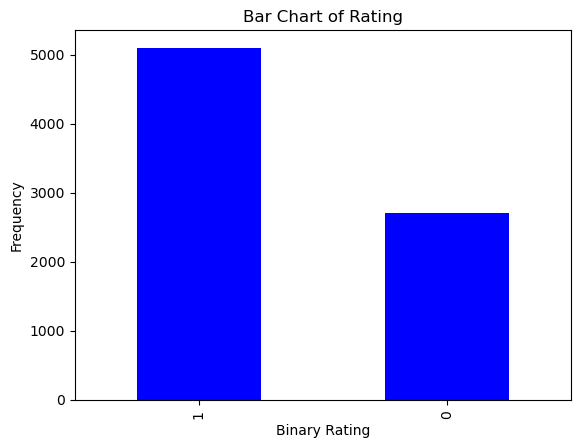

In [10]:
data['Binary Rating'].value_counts().plot(kind='bar', color='blue')
plt.xlabel('Binary Rating')
plt.ylabel('Frequency')
plt.title('Bar Chart of Rating')
plt.show()

In [11]:
data['Rating'].value_counts()

Rating
BBB     910
BBB+    846
A       836
A-      722
BBB-    705
BB+     545
A+      478
BB      453
BB-     427
B+      422
B       310
B-      288
AA-     254
AA      185
CCC+    151
AAA      90
AA+      73
CCC      65
CC       18
C        11
CCC-     10
D         5
CC+       1
Name: count, dtype: int64

Data is unbalanced, will have to balance it

In [12]:
data.isnull().sum()

Rating Agency                    0
Corporation                      0
Rating                           0
Rating Date                      0
CIK                              0
Binary Rating                    0
SIC Code                         0
Sector                           0
Ticker                           0
Current Ratio                    0
Long-term Debt / Capital         0
Debt/Equity Ratio                0
Gross Margin                     0
Operating Margin                 0
EBIT Margin                      0
EBITDA Margin                    0
Pre-Tax Profit Margin            0
Net Profit Margin                0
Asset Turnover                   0
ROE - Return On Equity           0
Return On Tangible Equity        0
ROA - Return On Assets           0
ROI - Return On Investment       0
Operating Cash Flow Per Share    0
Free Cash Flow Per Share         0
dtype: int64

In [13]:
rating_order = {
    'AAA': 1,
    'AA+': 2,
    'AA': 3,
    'AA-': 4,
    'A+': 5,
    'A': 6,
    'A-': 7,
    'BBB+': 8,
    'BBB': 9,
    'BBB-': 10,
    'BB+': 11,
    'BB': 12,
    'BB-': 13,
    'B+': 14,
    'B': 15,
    'B-': 16,
    'CCC+': 17,
    'CCC': 18,
    'CCC-': 19,
    'CC+': 20,
    'CC': 21,
    'C': 22,
    'D': 23
}

data['Rating_Order'] = data['Rating'].map(rating_order)
data = data.sort_values('Rating_Order')



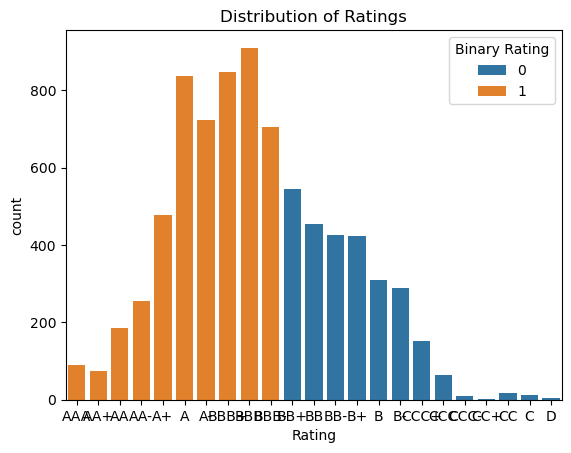

In [14]:
# rating_map = {"AAA": 1, "AA": 2, "A": 3, "BBB": 4, "BB": 5, "B": 6}
# portfolio["RatingNum"] = portfolio["Rating"].map(rating_map)

# sns.countplot(data=df, x="=target", hue="target")
sns.countplot(data, x="Rating", hue='Binary Rating')
plt.title("Distribution of Ratings")
plt.show()

In [15]:
#Drop unwanted Columns
cleaned_data = data.drop(columns = ['Rating Agency','Corporation','Ticker', 'SIC Code', 'CIK', 'Rating Date','Rating'], axis = 1)
cleaned_data.columns

Index(['Binary Rating', 'Sector', 'Current Ratio', 'Long-term Debt / Capital',
       'Debt/Equity Ratio', 'Gross Margin', 'Operating Margin', 'EBIT Margin',
       'EBITDA Margin', 'Pre-Tax Profit Margin', 'Net Profit Margin',
       'Asset Turnover', 'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share',
       'Rating_Order'],
      dtype='object')

In [16]:
print(cleaned_data['Binary Rating'].value_counts(normalize=True))

#Will have to one hot encode
print(cleaned_data['Sector'].unique())

print(cleaned_data['Sector'].value_counts())

Binary Rating
1    0.653299
0    0.346701
Name: proportion, dtype: float64
['Hlth' 'BusEq' 'Enrgy' 'Other' 'Utils' 'NoDur' 'Manuf' 'Shops' 'Chems'
 'Durbl' 'Telcm' 'Money']
Sector
Other    1251
Manuf     981
BusEq     958
Utils     843
Shops     786
Enrgy     665
Hlth      625
NoDur     567
Telcm     386
Chems     315
Durbl     221
Money     207
Name: count, dtype: int64


In [17]:
num_cols = cleaned_data.select_dtypes(include=['float64', 'int64']) 
cat_cols = cleaned_data.select_dtypes(include=['object']) 

print("Numeric Variables:")
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())


corr = num_cols.corr()

# Sort the correlations for the 'BAD' column in descending order
top_corr = corr['Binary Rating'].sort_values(ascending=False)[1:20].to_frame()

top_corr

Numeric Variables:
['Binary Rating', 'Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin', 'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover', 'ROE - Return On Equity', 'Return On Tangible Equity', 'ROA - Return On Assets', 'ROI - Return On Investment', 'Operating Cash Flow Per Share', 'Free Cash Flow Per Share', 'Rating_Order']

Categorical Variables:
['Sector']


,Binary Rating
ROA - Return On Assets,0.252535
Pre-Tax Profit Margin,0.224077
Net Profit Margin,0.207499
EBIT Margin,0.202285
Operating Margin,0.201165
ROI - Return On Investment,0.178099
EBITDA Margin,0.158042
Gross Margin,0.150972
ROE - Return On Equity,0.033373
Return On Tangible Equity,0.033032


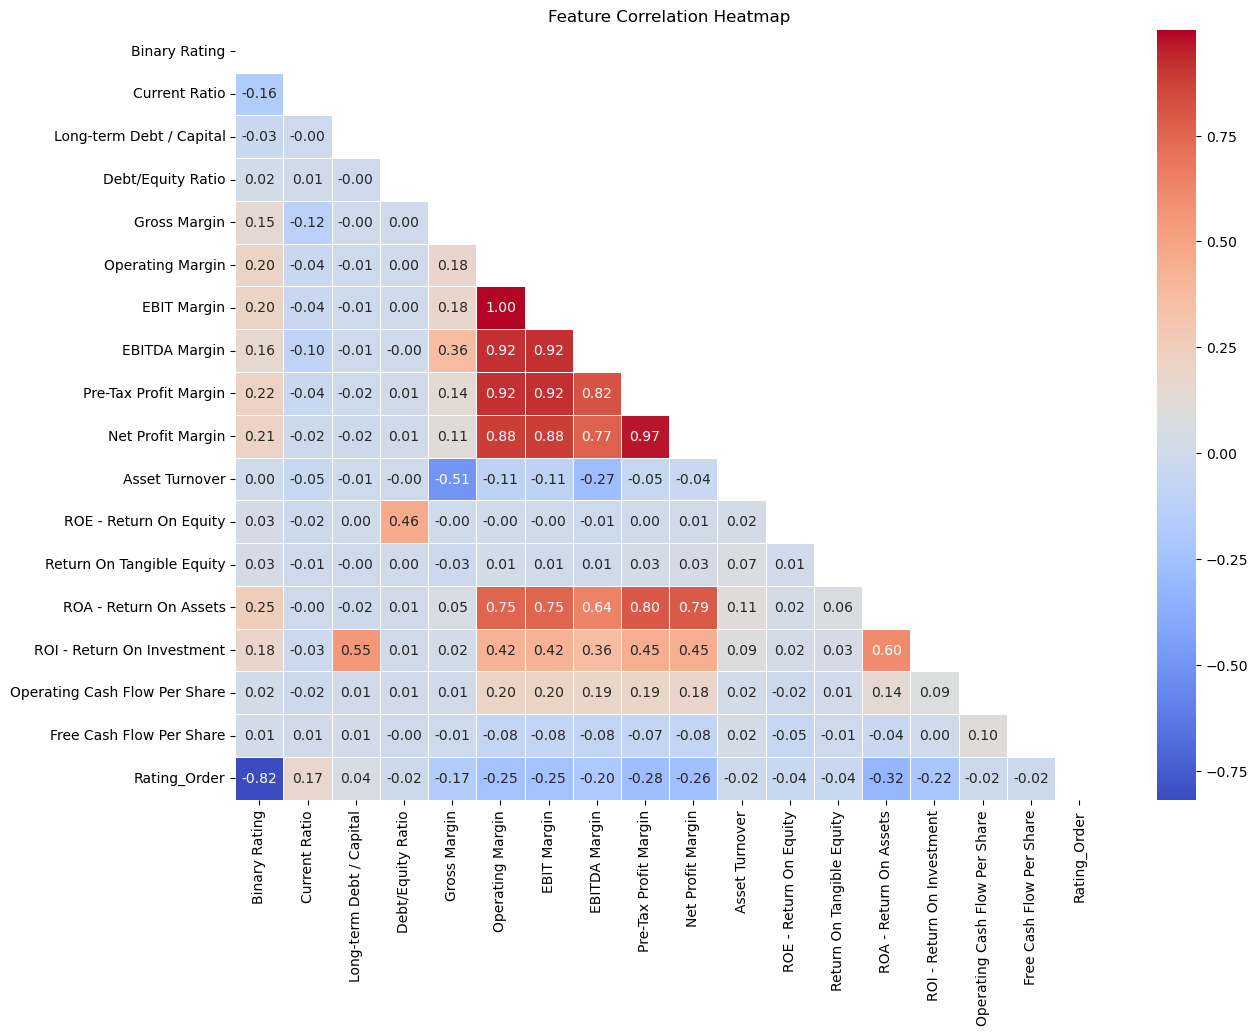

In [18]:
# Compute the correlation matrix
num_data = cleaned_data.select_dtypes(include=[np.number])  # Just in case
corr_matrix = num_data.corr()
#create heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [19]:
threshold = 0.8
high_corr = []

for col in corr_matrix.columns:
    for idx in corr_matrix.index:
        if col != idx and abs(corr_matrix.loc[idx, col]) > threshold:
            high_corr.append((idx, col, corr_matrix.loc[idx, col]))

# Remove duplicates (A,B) vs (B,A)
unique_pairs = list(set([tuple(sorted((a, b))) + (v,) for a, b, v in high_corr]))
for a, b, v in unique_pairs:
    print(f"{a} and {b} → Correlation: {v:.2f}")


Operating Margin and Pre-Tax Profit Margin → Correlation: 0.92
EBIT Margin and EBITDA Margin → Correlation: 0.92
EBIT Margin and Pre-Tax Profit Margin → Correlation: 0.92
EBITDA Margin and Pre-Tax Profit Margin → Correlation: 0.82
Binary Rating and Rating_Order → Correlation: -0.82
EBITDA Margin and Operating Margin → Correlation: 0.92
EBIT Margin and Net Profit Margin → Correlation: 0.88
Net Profit Margin and Pre-Tax Profit Margin → Correlation: 0.97
Net Profit Margin and Operating Margin → Correlation: 0.88
EBIT Margin and Operating Margin → Correlation: 1.00


In [20]:
#Dropping

drop_cols = [
    'EBITDA Margin',
    'Pre-Tax Profit Margin',
    'ROI - Return On Investment','Operating Margin', 'Binary Rating', 
    # Optional: 'EBIT Margin'
]



In [21]:
try:
    cleaned_data = cleaned_data.drop(columns=drop_cols)
except KeyError:
    print('Data already deleted')

In [22]:
cleaned_data.columns

Index(['Sector', 'Current Ratio', 'Long-term Debt / Capital',
       'Debt/Equity Ratio', 'Gross Margin', 'EBIT Margin', 'Net Profit Margin',
       'Asset Turnover', 'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'Operating Cash Flow Per Share',
       'Free Cash Flow Per Share', 'Rating_Order'],
      dtype='object')

In [23]:
cleaned_data = pd.get_dummies(cleaned_data, columns=['Sector'], drop_first=True)

print(cleaned_data.dtypes.value_counts())


float64    12
bool       11
int64       1
Name: count, dtype: int64


In [24]:
X = cleaned_data.drop(columns=['Rating_Order'])  # target columns
y = cleaned_data['Rating_Order']-1  # multiclass target


In [25]:
# Count class frequencies
class_counts = y.value_counts()

# Keep only classes with ≥ 5 examples (safe threshold)
valid_classes = class_counts[class_counts > 1].index

# Filter dataset
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

print("Dropped classes:", class_counts[class_counts <= 1])

# 2. Re-index class labels to 0-N
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.Series(y, name="Encoded Rating")

Dropped classes: Rating_Order
19    1
Name: count, dtype: int64


In [26]:


# Train/test split (with stratified sampling by rating)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [27]:
# Identify numeric columns only
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

# Standard scaling
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [28]:
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


c:\Users\aksha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:50:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[10  2  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  6  0  2  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 15  8  8  3  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 2  1  4 24  5  2  6  3  1  1  0  0  0  1  1  0  0  0  0  0  0  0]
 [ 1  0  7  4 57  9  5  6  4  1  1  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  4  5 20 72 31 13 16  3  0  1  0  0  1  1  0  0  0  0  0  0]
 [ 1  1  0  0  9 19 70 23 11  6  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  1  5  4 16 26 77 28  4  1  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  2  4 10 13 29 81 33  3  2  2  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1  2  6  6  4 35 62 19  1  4  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  3 14 21 42 15  3  5  2  1  1  0  0  0  0  0]
 [ 0  0  0  0  1  1  3  2  7  8 17 32  9  7  2  2  0  0  0  0  0  0]
 [ 0  0  0  0  2  1  2  2  4  4  6 14 31  9  5  3  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  5  4  5  3 14 29 16  5  1  0  0  0  0  0]
 [ 0  0  0  0  

c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


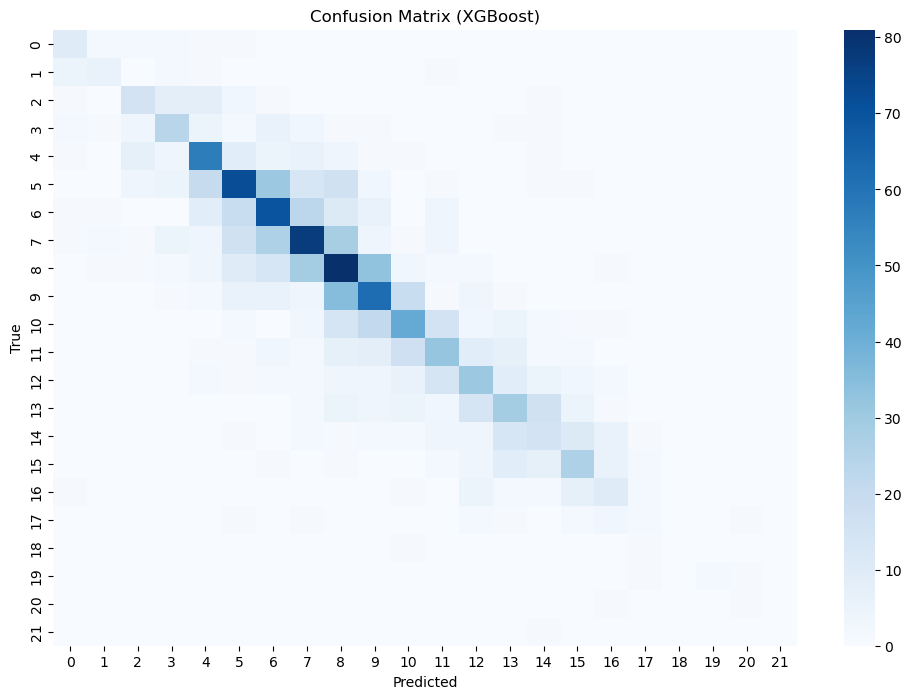

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Grouping Rating Classes into Broader Tiers

In [30]:
# Define the mapping
rating_to_tier = {
    'AAA': 0, 'AA+': 0, 'AA': 0, 'AA-': 0,
    'A+': 1, 'A': 1, 'A-': 1,
    'BBB+': 2, 'BBB': 2, 'BBB-': 2,
    'BB+': 3, 'BB': 3, 'BB-': 3,
    'B+': 4, 'B': 4, 'B-': 4,
    'CCC+': 5, 'CCC': 5, 'CCC-': 5, 'CC+': 5, 'CC': 5, 'C': 5, 'D': 5
}


cleaned_data["Binary Rating"] = data["Binary Rating"]  # Bring it back
cleaned_data["Rating"] = data["Rating"]  # Bring it back
cleaned_data["Rating_Tier"] = cleaned_data["Rating"].map(rating_to_tier)


In [31]:


X = cleaned_data.drop(columns=['Rating_Order', 'Rating_Tier'])
y = cleaned_data['Rating_Tier']


In [32]:
cleaned_data.columns

Index(['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio',
       'Gross Margin', 'EBIT Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'Operating Cash Flow Per Share',
       'Free Cash Flow Per Share', 'Rating_Order', 'Sector_Chems',
       'Sector_Durbl', 'Sector_Enrgy', 'Sector_Hlth', 'Sector_Manuf',
       'Sector_Money', 'Sector_NoDur', 'Sector_Other', 'Sector_Shops',
       'Sector_Telcm', 'Sector_Utils', 'Binary Rating', 'Rating',
       'Rating_Tier'],
      dtype='object')

In [33]:


# 1. Set up X and y
X = cleaned_data.drop(columns=["Rating_Tier", "Binary Rating", "Rating_Order", "Rating"])
y = cleaned_data["Rating_Tier"]

# 2. One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# 5. Train model
xgb = XGBClassifier(objective='multi:softmax', num_class=6, eval_metric='mlogloss', use_label_encoder=False)
xgb.fit(X_train, y_train)

# 6. Predictions
y_pred = xgb.predict(X_test)

# 7. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

from sklearn.metrics import accuracy_score
print("Accuracy Score:", accuracy_score(y_test, y_pred))


c:\Users\aksha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:50:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[ 81  34   5   0   1   0]
 [ 26 287  89   2   3   0]
 [ 11  82 357  40   2   0]
 [  0   7  40 202  33   3]
 [  0   3   8  32 151  10]
 [  0   0   2   2  19  29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       121
           1       0.69      0.71      0.70       407
           2       0.71      0.73      0.72       492
           3       0.73      0.71      0.72       285
           4       0.72      0.74      0.73       204
           5       0.69      0.56      0.62        52

    accuracy                           0.71      1561
   macro avg       0.71      0.68      0.69      1561
weighted avg       0.71      0.71      0.71      1561

Accuracy Score: 0.709160794362588


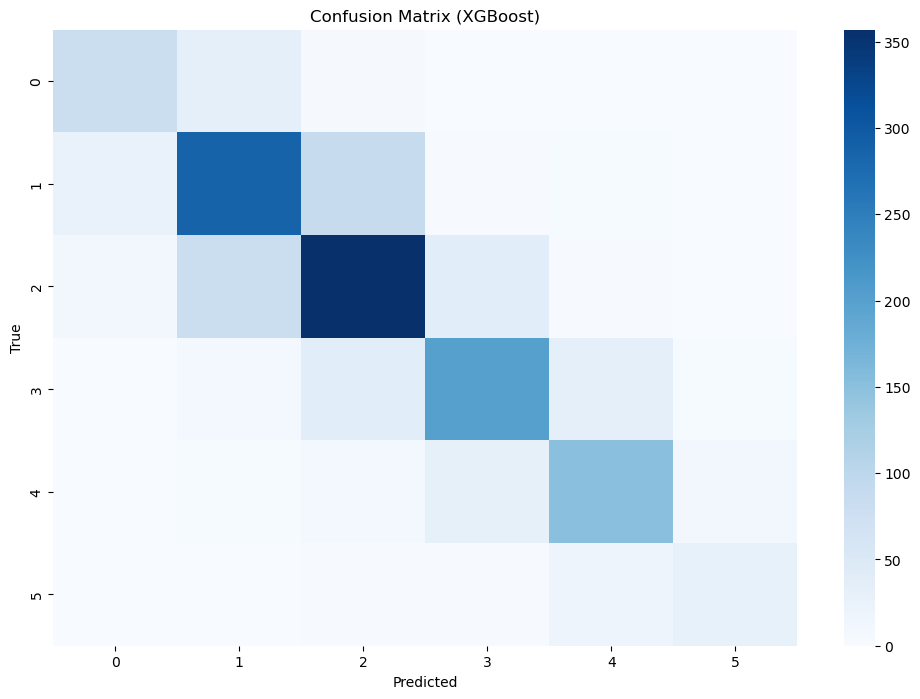

In [34]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [35]:
# Get feature names (drop target and non-feature columns)
feature_names = cleaned_data.drop(columns=["Rating_Tier", "Binary Rating", "Rating_Order", "Rating"]).columns

# Convert back to DataFrames
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

In [36]:
import shap
shap.initjs()  # Initialize JS visualizations for SHAP

# took an hour to run damn
# explainer = shap.Explainer(model, X_train_df)
# shap_values = explainer(X_test_df)



In [37]:
# shap.summary_plot(shap_values[..., 0], X_test_df)  # For class 0, e.g. "AAA"
# shap.summary_plot(shap_values, X_test_df, class_names=model.classes_)
# Pick one test sample (you can change the index!)
# index = 10
# shap.plots.waterfall(shap.Explanation(values=shap_values[index], 
#                                       base_values=explainer.expected_value[index], 
#                                       data=X_test_df.iloc[index], 
#                                       feature_names=X_test_df.columns.tolist()))



TRYING ENSEMBLING METHODS

In [38]:
# %%
# ------------------------------------------------------------------------------
# Import Additional Libraries for Ensembling
# ------------------------------------------------------------------------------
# We are adding RandomForest, LogisticRegression, LightGBM, and the VotingClassifier itself.
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier # <-- Added LightGBM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# NOTE: The following data preparation steps are assumed to have been run,
# as they are identical to your original script. This code block focuses
# on the new ensembling part.

# --- [ASSUMED PREVIOUS CODE] ---
# data = pd.read_csv("Dataset.csv")
# y = ... # Target variable
# X_train, X_test, y_train, y_test = ... # Train-test split data
# --- [END OF ASSUMED CODE] ---


In [39]:


# %%
# ------------------------------------------------------------------------------
# Define the Individual Models (Estimators) for the Ensemble
# ------------------------------------------------------------------------------

# 1. XGBoost Classifier
# This is the same powerful model you used before.
clf1 = XGBClassifier(
    objective='multi:softmax',  # Specifies the learning objective for multi-class classification.
    num_class=len(y.unique()),   # Tells the model how many distinct classes there are to predict.
    eval_metric='mlogloss',     # The evaluation metric to be used for validation data.
    use_label_encoder=False,    # Suppresses a deprecation warning.
    random_state=42             # Ensures reproducibility of the results.
)

# 2. Random Forest Classifier
# This model builds multiple decision trees and merges them together.
# It's robust and handles complex interactions well.
clf2 = RandomForestClassifier(
    n_estimators=100,           # The number of trees in the forest. More trees can improve performance but take longer to train.
    random_state=42             # Ensures that the results are the same every time we run the code.
)

# 3. Logistic Regression
# A linear model that is simple, fast, and provides a different "perspective" on the data.
clf3 = LogisticRegression(
    multi_class='multinomial',  # Specifies the strategy for handling multiple classes.
    solver='lbfgs',             # The algorithm to use in the optimization problem. 'lbfgs' is a good default.
    max_iter=1000,              # Maximum number of iterations for the solver to converge. Increased to avoid convergence warnings.
    random_state=42             # Ensures reproducibility.
)

# 4. LightGBM Classifier (NEW)
# A fast, high-performance gradient boosting framework similar to XGBoost.
clf4 = LGBMClassifier(
    objective='multiclass',     # Specifies the learning objective.
    n_estimators=100,           # The number of boosting rounds.
    random_state=42             # Ensures reproducibility.
)



In [40]:

# %%
# ------------------------------------------------------------------------------
# Create the Ensemble Voting Classifier
# ------------------------------------------------------------------------------

# The VotingClassifier combines the predictions from the models we just defined.
# 'estimators' is a list of tuples, with a name and the model object for each classifier.
# 'voting='soft'' tells the ensemble to average the prediction probabilities from each model.
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', clf1),
        ('rf', clf2),
        ('lr', clf3),
        ('lgbm', clf4) # <-- Added LightGBM to the panel of experts
    ],
    voting='soft'
)

# %%
# ------------------------------------------------------------------------------
# Train and Evaluate the Ensemble Model
# ------------------------------------------------------------------------------

# Train the entire ensemble on the training data.
# This will individually train all four models.
print("Training the ensemble model...")
ensemble_model.fit(X_train, y_train)
print("Training complete.")

# Use the trained ensemble to make predictions on the unseen test data.
y_pred_ensemble = ensemble_model.predict(X_test)


Training the ensemble model...


c:\Users\aksha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:50:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3093
[LightGBM] [Info] Number of data points in the train set: 6244, number of used features: 23
[LightGBM] [Info] Start training from score -2.563509
[LightGBM] [Info] Start training from score -1.343655
[LightGBM] [Info] Start training from score -1.154095
[LightGBM] [Info] Start training from score -1.700593
[LightGBM] [Info] Start training from score -2.034962
[LightGBM] [Info] Start training from score -3.397042
Training complete.


In [43]:

# %%
# ------------------------------------------------------------------------------
# Display the Performance of the Ensemble
# ------------------------------------------------------------------------------

# Calculate the overall accuracy of the ensemble model.
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)

# Print the final evaluation metrics.
print("\n--- Ensemble Model Performance ---")
print(f"Accuracy Score: {ensemble_accuracy:.4f}\n")  # Prints the accuracy formatted to 4 decimal places.

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble)) # Shows where the model made correct vs. incorrect predictions for each class.

print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble)) # Provides precision, recall, and f1-score for each class.




--- Ensemble Model Performance ---
Accuracy Score: 0.7015

Confusion Matrix:
[[ 75  40   5   0   1   0]
 [ 23 293  87   1   3   0]
 [  8  84 359  36   5   0]
 [  0   7  51 190  36   1]
 [  0   3  11  30 151   9]
 [  0   0   3   1  21  27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       121
           1       0.69      0.72      0.70       407
           2       0.70      0.73      0.71       492
           3       0.74      0.67      0.70       285
           4       0.70      0.74      0.72       204
           5       0.73      0.52      0.61        52

    accuracy                           0.70      1561
   macro avg       0.71      0.67      0.68      1561
weighted avg       0.70      0.70      0.70      1561

